# Computing the variational free energy in categorical models

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/infer-actively/pymdp/blob/master/docs/notebooks/free_energy_calculation.ipynb)

*Author: Conor Heins*

This notebook walks the user through the computation of the variational free energy (or *VFE*) for discrete generative models, composed of categorical distributions. We can represent these sorts of generative models easily in array-focused programming languages like `NumPy` and `MATLAB` using matrices and vectors.

In the discrete state-space formulation, the variational free energy is very straightforward to compute when we take advantage of the NDarray representation of probability distributions. The highly-optimized matrix algebra built into today's numerical computing paradigms can be exploited to write simple, one-line expressions for information-theoretic terms (like Kullback-Leibler divergences, cross-entropies, log-likelihoods, etc.). All these terms end up being variants of things like inner products, matrix-vector products or matrix-matrix multiplications.

This notebook is inspired by the supplementary MATLAB script for the paper ["A Step-by-Step Tutorial on Active Inference Modelling and its Application to Empirical Data"](https://www.sciencedirect.com/science/article/pii/S0022249621000973) by Ryan Smith, Karl Friston, and Christopher Whyte. The original MATLAB script is called `VFE_calculation_example.m`, and can be found on [Ryan Smith's GitHub repository](https://github.com/rssmith33/Active-Inference-Tutorial-Scripts), which also contains a set of tutorial scripts that are supplementary to their paper.

*Note*: When running this notebook in Google Colab, you may have to run `!pip install inferactively-pymdp` at the top of the notebook, before you can `import pymdp`. That cell is left commented out below, in case you are running this notebook from Google Colab.

In [1]:
# ! pip install inferactively-pymdp

### Imports

First, import `pymdp` and the modules we'll need.

In [2]:
import os
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

path = pathlib.Path(os.getcwd())
module_path = str(path.parent) + '/'
sys.path.append(module_path)

from pymdp import utils, maths

### A simple generative model composed of a likelihood and a prior

We begin by constructing a simple generative model composed of two sets of categorical distributions: a likelihood distribution $P(o|s)$ and a prior distribution $P(s)$. 

Because both of these distributions are categorical distributions, we can represent them easily in code using matrices and vectors. The likelihood distribution is a conditional distribution that tells the probability that the generative model assigns to different observations, given different hidden states. Since observations and hidden states are both discrete, this can be efficiently represented as a matrix, each of whose **columns** store the conditional probabilities of all the observations (the **rows**), given a particular hidden state. Each hidden state setting is thus indexed by a column. For this reason, each column of this matrix is a categorical probability distributions and its entries must sum to one. 

The prior is represented as a 1-D vector and stores the prior probabilities that the generative model assigns to each hidden state. 

Finally, to set ourselves up later for showing model inversion and free energy calculations, we initialize an observation that we assume the agent or generative model has "gathered" or "seen." In `pymdp` we can represent these observations either as one-hot vectors (a `1` in one entry, and `0`'s everywhere else) or more sparsely as simple indices (integers) that represent *which* of the observations was observed. Because observations are not distributions (or technically, they are Dirac distributions), you don't need to store a whole vector of elements, you can just store a particular index.

Below we create 3 main variables: 

- An `observation` that represents a real observation that the agent or generative model "sees". 
- The `prior` distribution that represents the agent's prior beliefs about the hidden states
- the `likliheood_dist` that represents the agent's beliefs about how hidden states probabilistically relate to observations.


In [3]:
## Define a quick helper function for printing arrays nicely (see https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75)
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [4]:
num_obs = 2 # dimensionality of observations (2 possible observation levels)
num_states = 2 # dimensionality of observations (2 possible hidden state levels)

observation = 0 # index representation
# observation = np.array([1, 0]) # one hot representation
# observation = utils.onehot(0, num_obs) # one hot representation, but use one of pymdp's utility functions to create a one-hot

prior = np.array([0.5, 0.5]) # simply set it by hand
# prior = np.ones(num_states) / num_states # create a uniform prior distribution by creating a vector of ones and dividing each by the number of states
# prior = utils.norm_dist(np.ones(num_states)) # use one of pymdp's utility functions to normalize any vector into a probability distribution

likelihood_dist = np.array([ [0.8, 0.2],
                        [0.2, 0.8] ])

if isinstance(observation, np.ndarray):
    print(f'Observation:{observation}\n')
else:
    print(f'Observation: {observation}\n')
print(f'Prior:{prior}\n')
print('Likelihood:')
matprint(likelihood_dist)


Observation: 0

Prior:[0.5 0.5]

Likelihood:
0.8  0.2  
0.2  0.8  


### Bayesian inference

Before we define variational free energy for this generative model, let's step through the computations involved in inverting this model using Bayes' rule, i.e. computing the optimal Bayesian posterior over hidden states, given our sensory observation (which we will formally refer to as $o_t$). By performing exact Bayesian inference first, we can directly compares its results to that of variational free energy minimization. This will help us better understand the meaning of the free energy calculations that come later.

#### 1. Compute the likelihood over hidden states, given the observation 

Now that we have a generative model and have fixed a particular observatio $o_t$ (`observation`), we have to perform Bayes' rule to compute the posterior. Mathematically, this can be expressed as follows:

### $ \hspace{60mm} P(s | o _t) = \frac{P(o = o_t | s)P(s)}{P(o = o_t)} $

Computing the posterior via Bayes' rule (also known as "model inversion") is the essence of optimal statistical inference, when one has a generative model of how one's data is caused, and some data. 

To start with, let's computing the likelihood term $P(o = o_t | s)$. We can represent the computation of the likelihood with this line of `NumPy`: ``likelihood_dist[observation,:]``. By doing so, we are providing a numerical answer to the question: "What is the likelihood that State 1 vs State 2 caused the actual sensory data $o_t$ that I've observed?".

 Mathematically, our likelihood function $P(o = o_t | s)$ (in the statistics literature also referred to as $L(\theta)$) is a *function of the hidden states*. The particular function over hidden states we use is *defined* by the observation $o_t$. So you can think of the likelihood as a multi-dimensional function or simply a space of functions, where the particular function you use for inference is determined by your data.

This act of computing the likelihood via an indexing  operation ``likelihood_dist[observation,:]``, is similar in spirit to the operation of *conditioning*. We are, in some sense, "conditioning" on a particular observation (slicing out a "row" of our ``likelihood_dist`` matrix), and then looking at the *induced* likelihood over possible causes (hidden states) that could've have been the latent source of that observation. This operation captures the essence of what we mean when we speak of "inverting" generative models. Generative models are referred to as *generative* because they can be used to generate fictive observations, given some fixed setting of latent parameters. *Inversion* is thus moving in the opposite direction -- given some sensory data, what is the consequent likelihood over the *causes* or hidden states that might have generated that data?

**Note**: We can also compute the likelihood using a matrix-vector product, if the observation is represented as a one-hot vector.

```
likelihood_s = likelihood_dist.T @ observation
```

You can see think of this as a weighted average of the rows of the likelihood matrix, where the weights are provided by the observations. Since we have insisted that the observations are a one-hot vector, this is equivalent to just selecting a single row of the likelihood matrix (the one indexed by the entry of the observation that is `1.0`).

In [5]:

if isinstance(observation, np.ndarray): # use the matrix-vector version if your observation is a one-hot vector
    likelihood_s = likelihood_dist.T @ observation
elif isinstance(observation, int): # use the index version if your observation is an integer index
    likelihood_s = likelihood_dist[observation,:] 
display(Latex(f'$P(o=o_t|s):$'))
print(f'{likelihood_s}')
print('==================\n')


<IPython.core.display.Latex object>

[0.8 0.2]



#### 2. The joint distribution $P(o = o_t, s) = P(o = o_t|s)P(s)$ 

To compute the full numerator on the right-hand side of the Bayes' rule equation, we need to compute the joint distribution $P(o = o_t|s)P(s)$.

The joint distribution, which also fully defines the generative model, is the product of the likelihood and prior distributions. The joint distribution expresses the joint probability of observations and hidden states, given the likelihood distribution and the prior over hidden states. If we condition on an actual observation $o_t$, as we have done here, then this joint distribution is, like the likelihood, a function of hidden states. 

In [6]:
joint_prob = likelihood_s * prior # element-wise product of the likelihood of each hidden state, given the observation, with the prior probability assigned to each hidden state
display(Latex(f'$P(o = o_t,s) = P(o = o_t|s)P(s):$'))
print(f'{joint_prob}')
print('==================\n')

<IPython.core.display.Latex object>

[0.4 0.1]



#### 3. Marginal probability or marginal likelihood: $\sum_s P(o = o_t, s) = P(o = o_t)$

Let's remind ourselves of Bayes' rule below:

#### $ \hspace{60mm} P(s | o _t) = \frac{P(o = o_t | s)P(s)}{P(o = o_t)} $

So far, using the likelihood, the observation, and the prior, we have computed the numerator of this term: the unnormalized joint distribution $P(o = o_t,s)$. All that's left is to do is then divide this term by the denominator $P(o=o_t)$. This term is also referred to as the model evidence or the marginal likelihood. 

This can be thought of as the probability of having seen the particular observation you saw, under all possible settings of the hidden states. This can be computed by marginalizing the joint distribution, using the prior probabilities of the hidden states:

#### $ \hspace{60mm}P(o) = \sum_s P(o|s)P(s)$

In [7]:
p_o = joint_prob.sum()

#### 4. Compute the posterior $P(s|o=o_t)$

Now to compute the Bayes-optimal posterior, simply divide the numerator by the denominator!

In [8]:
posterior = joint_prob / p_o # divide the joint by the marginal
display(Latex('$P(s|o = o_t) = \\frac{P(o = o_t,s)}{P(o=o_t)}$:'))
print(f'Posterior over hidden states: {posterior}')
print('==================')

<IPython.core.display.Latex object>

Posterior over hidden states: [0.8 0.2]


### The variational free energy

The variational free energy is an upper bound on **surprise**: surprise is define as $ - \ln p(o)$, and is also known as the negative (log) evidence. By minimizing free energy, we are **minimizing** surprise and thus **maximizing** log evidence.  This evidence is simply the (log of the) term we computed in the previous step, the normalizing denominator used in Bayes' rule. We can thus first compute the surprise associated with the observation we saw earlier:

In [9]:
surprise = - np.log(p_o)

display(Latex('$- \ln P(o=o_t)$:'))
print(f'Surprise: {surprise.round(3)}')
print('==================')

<IPython.core.display.Latex object>

Surprise: 0.693


By minimizing variational free energy with respect to the parameters of an arbitrary, parametrized distribution, also known as the approximate or variational posterior $Q(s)$, we are forcing the surprise to go down, and the model evidence to go up. In doing so, the approximate posterior distribution will get "closer" to the true posterior distribution (the $P(s|o)$ we computed above), $Q(s) \approx P(s|o)$.

This idea of minimizing a bound on surprise, is the core principle underlying the variational free energy principle, active inference, and the statistical methodology of variational principles more generally. This comes in handy because in many realistic scenarios where agents or systems need to make inferences about the hidden causes of sensory perturbations, performing Bayesian inference exactly becomes intractable (due mostly to the computation of the $P(o)$ denominator term, also known as the normalizing constant). Variational inference turns this intractable marginalization problem into a tractable optimization problem, where one only needs to change the approximate posterior $Q(s)$ in order to minimize a bound on surprise.

But what is the variational free energy exactly, mathematically? It is commonly written as the expectation, under the approximate posterior, of the log ratio between the approximate posterior and the generative model:

#### $ \hspace{60mm} \mathcal{F} = \mathbb{E}_{Q(s)}[\ln \frac{Q(s)}{P(o, s)}] $

Because of the rules of logarithms, we can also express this as an expected difference between the log posterior and the log generative model:

#### $ \hspace{60mm} \mathcal{F} = \mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(o, s)] $

By doing taking advantage of some more mathematical relationships (the factorization of the joint, rules for logarithms of products, and the definition of the conditional expectation), we can re-write this as an upper bound on surprise:

#### $ \hspace{60mm} \mathcal{F} = \mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(s|o)] - \ln P(o) $

By re-arranging this equality and taking advantage of the fact that the quantity $\mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(s|o)]$ (also known as the Kullback-Leibler divergence) is greater than or equal to 0, we can easily show that the VFE is an upper bound on surprise:

#### $ \hspace{60mm} \mathcal{F} \geq - \ln P(o) $

Let's now compute the VFE numerically for our generative model and fixed observation. Given we already defined those two things ($o_t$ and $P(o,s)$), the last thing we need to do, is to define an initial setting of our approximate posterior $Q(s)$, and compute the variational free energy using one of the formulas above.

In [10]:
# to begin with, set our initial Q(s) equal to our prior distribution -- i.e. a flat/uninformative belief about hidden states
initial_qs = np.array([0.5, 0.5])

# redefine generative model and observation, for ease
observation = 0
likelihood_dist = np.array([[0.8, 0.2], [0.2, 0.8]])
prior = utils.norm_dist(np.ones(2))

# compute the joint or generative model using the factorization: P(o=o|s)P(s)
joint_prob = likelihood_dist[observation,:] * prior

# compute the variational free energy using the expected log difference formulation
initial_F = initial_qs.dot(np.log(initial_qs) - np.log(joint_prob))
## @NOTE: because of log-rules, `initial_F` can also be computed using the division inside the logarithm:
# initial_F = initial_qs.dot(np.log(initial_qs/joint_prob))

display(Latex('$\mathcal{F} = \mathbb{E}_{Q(s)}[\ln \\frac{Q(s)}{P(o, s)}] = \mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(o, s)]:$'))
print(f'Variational free energy (F) = {initial_F.round(3)}')
print('==================')

<IPython.core.display.Latex object>

Variational free energy (F) = 0.916


Now let's then change the approximate posterior $Q(s)$ and see what happens to the variational free energy.

By definition, optimal inference (and 'perfect' VFE minimization) obtains when we set the approximate posterior $Q(s)$ to be equal to the true posterior, $Q(s) = P(s|o)$. 

As an extreme case, let's do this and then measure the variational free energy. We can see that it has decreased, relative to it's initial setting when the approximate posterior was equal to the prior $P(s)$.

In [11]:
final_qs = posterior.copy() # now we just assert that the approximate posterior is equal to the true posterior
final_F = final_qs.dot(np.log(final_qs) - np.log(joint_prob))

display(Latex('$\mathcal{F} = \mathbb{E}_{Q(s)}[\ln \\frac{Q(s)}{P(o, s)}] = \mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(o, s)]:$'))
print(f'F = {final_F.round(3)}')
print('==================')

<IPython.core.display.Latex object>

F = 0.693


Notice that the free energy is 0.693 -- if you recall, this is exactly the **surprise** or negative log marginal likelihood $-\ln P(o = o_t)$, related to the marginal likelihood quantity $P(o=o_t)$ that we had to compute when performing exact Bayesian inference earlier. 

It is easy to see why this equality should hold, when we consider the VFE in terms of the surprise bound:

#### $ \hspace{60mm} \mathcal{F} = \mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(s|o)] - \ln P(o) $

When $Q(s) = P(s|o)$, as we have enforced with the line ``final_qs = posterior.copy()`` above, the first term $\mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(s|o)]$ will become 0. This is a property of the Kullback-Leibler divergence between two distributions $\operatorname{D}_{KL}(Q \parallel P) = \mathbb{E}_{Q}[\ln Q - \ln P]$. 

So since that KL divergence is 0, this is a case when the bound on surprise is exact:

#### $ \hspace{60mm} \mathcal{F} = 0 - \ln P(o) = - \ln P(o)$

In other words, minimizing free energy "as much as possible" in the case of this generative model, means that the approximate posterior equals the true posterior, and the free energy bound becomes "tight", i.e. the free energy simply IS the negative log evidence!

In [12]:
# compute the surprise (which we can do analytically for this simple generative model)
p_o = joint_prob.sum()
surprise = - np.log(p_o)
display(Latex('$-\ln P(o):$'))
print(f'{surprise.round(3)}')
print('==================\n')

<IPython.core.display.Latex object>

0.693



### Bonus material: auto-differentiation to perform gradient descent on the variational free energy

In this section, we are going to numerically differentiate the variational free energy with respect to the parameters of the approximate posterior. We can take advantage of modern autodifferentiation software, that can calculate the derivatives of arbitrary computer programs, to compute these derivatives without doing any analytic differentiation.

In [13]:
import autograd.numpy as np_auto   # Thinly-wrapped version of Numpy that is auto-differentiable
from autograd import grad          # this is the function that we use to evaluate derivatives
from functools import partial

First, let's create a variational free energy function, that takes as input the variational posterior `qs`, an observation `obs`, the likelihood matrix `likelihood` and a prior distribution `prior`.

By defining this computation as a function, we can calculate its derivatives automatically using the autodifferentiation package `autograd`, which allows users to pass gradients through arbitrary Python code. It includes a special version of `numpy` (`autograd.numpy`) that has a differentiable back-end. We will thus use this "special" verison of `numpy` when we instantiate our arrays and perform numerical operations on them.

In [14]:
# define the variational free energy as a function of the approximate posterior, an observation, and the generative model
def vfe(qs, obs, likelihood, prior):
    """
    Quick docstring below on inputs
    Arguments:
    =========
    `qs` [1D np_auto.ndarray]: variational posterior over hidden states
    `obs` [int]: index of the observation
    `likelihood` [2D np_auto.ndarray]: likelihood distribution P(o|s), relating hidden states probabilistically to observations
    `prior` [1D np_auto.ndarray]: prior over hidden states
    """

    likelihood_s = likelihood[obs,:]

    joint = likelihood_s * prior

    vfe = qs @ (np_auto.log(qs) - np_auto.log(joint))

    return vfe

# initialize an observation, an initial variational posterior, a prior, and a likelihood matrix
obs = 0
init_qs = np_auto.array([0.5, 0.5])
prior = np_auto.array([0.5, 0.5])
likelihood_dist = np_auto.array([ [0.8, 0.2],
                        [0.2, 0.8] ])

# this use of `partial` creates a version of the vfe function that is a function of Qs only, 
# with the other parameters (the observation, the generative model) fixed as constant parameters
vfe_qs = partial(vfe, obs = obs, likelihood = likelihood_dist, prior = prior)

# By calling `grad` on a function, we get out a function that can be used to compute the gradients of the VFE with respect to its input (in our case, `qs`)
grad_vfe_qs = grad(vfe_qs)

Now that we have a variational free energy function, and a derivative function that will give us the gradients of the VFE, with respect $Q(s)$, we can use it to perform a gradient descent on VFE, with respect to the parameters of $Q(s)$. In other words, we will implement this discretized differential equation to update the approximate posterior:

#### $ \hspace{60mm} Q(s)_{t+1} =Q(s)_{t} - \frac{\partial \mathcal{F}}{\partial Q(s)_{t}} $

Where the gradient term $\frac{\partial \mathcal{F}}{\partial Q(s)_{t}}$ will simply be the output of the gradient function `grad_vfe_qs` we've defined above.




In [15]:
# number of iterations of gradient descent to perform
n_iter = 40

qs_hist = np_auto.zeros((n_iter, 2))
qs_hist[0,:] = init_qs

vfe_hist = np_auto.zeros(n_iter)
vfe_hist[0] = vfe_qs(qs = init_qs)

learning_rate = 0.1 # learning rate to prevent gradient steps that are too big (overshooting)
for i in range(n_iter-1):   

    dFdqs = grad_vfe_qs(qs_hist[i,:])

    ln_qs = np_auto.log(qs_hist[i,:]) - learning_rate * dFdqs # transform qs to log-space to perform gradient descent
    qs_hist[i+1,:] = maths.softmax(ln_qs) # re-normalize to make it a proper, categorical Q(s) again

    vfe_hist[i+1] = vfe_qs(qs = qs_hist[i+1,:]) # measure final variational free energy

Since we were storing the history of the variational free energy over the course of the gradient descent, we can plot its trajectory below.

Text(0.5, 1.0, 'Gradient descent on VFE')

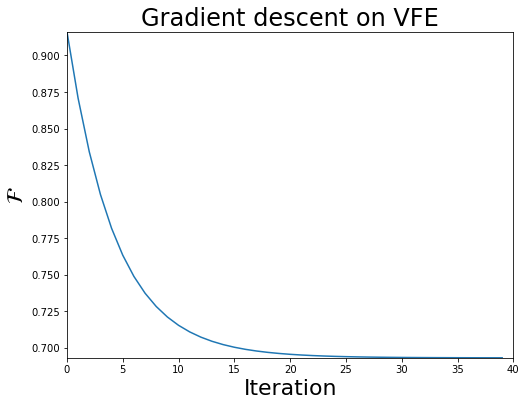

In [16]:
fig = plt.figure(figsize=(8,6))
plt.plot(vfe_hist)
plt.ylabel('$\\mathcal{F}$', fontsize = 22)
plt.xlabel("Iteration", fontsize = 22)
plt.xlim(0, n_iter)
plt.ylim(vfe_hist[-1], vfe_hist[0])
plt.title('Gradient descent on VFE', fontsize = 24)

In [17]:
final_qs, initial_F, final_F = qs_hist[-1,:], vfe_hist[0], vfe_hist[-1]

display(Latex('$\mathcal{F} = \mathbb{E}_{Q(s)}[\ln \\frac{Q(s)}{P(o, s)}] = \mathbb{E}_{Q(s)}[\ln Q(s) - \ln P(o, s)]:$'))
print(f'Initial F = {initial_F.round(3)}')
print('==================')

print('Final posterior:')
print(f'{final_qs.round(1)}') # note that because of numerical imprecision in the gradient descent (constant learning rate, etc.), the approximate posterior will not exactly be the optimal posterior
print('==================')
print(f'Final F = {vfe_qs(final_qs).round(3)}')
print('==================')


<IPython.core.display.Latex object>

Initial F = 0.916
Final posterior:
[0.8 0.2]
Final F = 0.693
